In [1]:
!pip install ripser

In [2]:
from pymoo.problems import get_problem
from tqdm import tqdm
import pandas as pd
from utils import *
from pymoo.vendor.vendor_coco import COCOProblem
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import time
import polars as pl
from ripser import ripser
from persim import plot_diagrams
import seaborn as sns

In [3]:
def generate_points_on_line(start_point, end_point, num_points):
    t_values = np.linspace(0, 1, num_points)
    start_point = np.array(start_point)
    end_point = np.array(end_point)
    points_on_line = start_point + t_values[:, np.newaxis] * (end_point - start_point)
    return points_on_line

def diagram_points(x):
    N = len(x)
    I = np.arange(N-1)
    J = np.arange(1, N)
    V = np.maximum(x[0:-1], x[1::])
    I = np.concatenate((I, np.arange(N)))
    J = np.concatenate((J, np.arange(N)))
    V = np.concatenate((V, x))
    #Create the sparse distance matrix
    D = sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()
    dgm0 = ripser(D, maxdim=0, distance_matrix=True)['dgms'][0]
    dgm0 = dgm0[dgm0[:, 1]-dgm0[:, 0] > 1e-3, :]
    allgrid = np.unique(dgm0.flatten())
    allgrid = allgrid[allgrid < np.inf]
    xs = np.unique(dgm0[:, 0])
    ys = np.unique(dgm0[:, 1])
    ys = ys[ys < np.inf]
    return xs, ys, dgm0

In [4]:
start = [-5, -5]
end = [5, 5]
#start = [-5, 5]
#end = [5, -5]
num_points = 1000
dim = 2

In [5]:
points = generate_points_on_line(start, end, num_points)
points

array([[-5.        , -5.        ],
       [-4.98998999, -4.98998999],
       [-4.97997998, -4.97997998],
       ...,
       [ 4.97997998,  4.97997998],
       [ 4.98998999,  4.98998999],
       [ 5.        ,  5.        ]])

In [6]:
features = []

for problem_index in range(1, 25):
    for instance_index in range(1, 16):
        problem_name = f"bbob-f{problem_index}-{instance_index}"
        problem = COCOProblem(problem_name, n_var=dim)
        y = problem.evaluate(points).flatten()
        y = (y - np.min(y)) / (np.max(y) - np.min(y))
        _, _, dgm0 = diagram_points(y)
        dgm0[np.isinf(dgm0)] = 1
        #print(problem_index, instance_index, dgm0.shape[0])
        data = {
            'problem': problem_index,
            'instance': instance_index,
            'bar|count|log': np.log(dgm0.shape[0]),
            'bar|len|mean': np.mean(dgm0[:, 1]-dgm0[:, 0]),
            #'bar|len|median': np.median(dgm0[:, 1]-dgm0[:, 0]),
            #'bar|len|quantile_25': np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.25),
            #'bar|len|quantile_75': np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.75),
            #'bar|len|quantile_05': np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.05),
            #'bar|len|quantile_95': np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.95),
            #'bar|1': np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.1)/np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.2),
            #'bar|2': np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.2)/np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.3),
            #'bar|3': np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.3)/np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.4),
            #'bar|4': np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.4)/np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.5),
            #'bar|5': np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.5)/np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.6),
            #'bar|n1': np.quantile(dgm0[:, 0],0.05)-np.quantile(dgm0[:, 0],0.1),
            #'bar|n2': np.quantile(dgm0[:, 0],0.1)-np.quantile(dgm0[:, 0],0.15),
            #'bar|n3': np.quantile(dgm0[:, 0],0.15)-np.quantile(dgm0[:, 0],0.2),
            #'bar|n4': np.quantile(dgm0[:, 0],0.2)-np.quantile(dgm0[:, 0],0.25),
            #'bar|n5': np.quantile(dgm0[:, 0],0.25)-np.quantile(dgm0[:, 0],0.3),
        }
        features.append(data)
        
fdf = pl.DataFrame(features)
fdf

problem,instance,bar|count|log,bar|len|mean
i64,i64,f64,f64
1,1,0.0,1.0
1,2,0.0,1.0
1,3,0.0,1.0
1,4,0.0,1.0
1,5,0.0,1.0
…,…,…,…
24,11,4.875197,0.278456
24,12,5.236442,0.357099
24,13,4.718499,0.196314


In [7]:
#np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.1)/np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.2)

In [8]:
#np.quantile(dgm0[:, 1]-dgm0[:, 0], 0.2)

In [9]:
save_dir = 'lio_problem'
runs_dir = f'{save_dir}/runs'
performance = pl.read_parquet(f'{runs_dir}/*')

performance.sort(['problem', 'instance'])

GA,PSO,DE,CMAES,ES,algorithm_run,problem,instance,optimum
f64,f64,f64,f64,f64,i64,i32,i32,f64
79.480002,79.48,79.48,79.48,79.481463,0,1,1,79.48
79.480005,79.48,79.48,79.48,79.480588,1,1,1,79.48
79.480018,79.48,79.48,79.48,79.480885,2,1,1,79.48
79.480001,79.48,79.48,79.48,79.480074,3,1,1,79.48
79.480001,79.48,79.48,79.48,79.48349,4,1,1,79.48
…,…,…,…,…,…,…,…,…
165.237321,163.966211,165.145521,155.729046,161.44505,24,24,15,149.81
160.237609,164.695048,163.771926,157.201823,168.96747,25,24,15,149.81
166.914187,154.651195,162.012215,150.327537,165.863525,21,24,15,149.81


In [10]:
performance_ranks = get_ranks(performance).group_by(['problem','instance']).mean().with_columns([
    pl.col("problem").cast(pl.Int64),
    pl.col("instance").cast(pl.Int64)
])
performance_ranks = performance_ranks.sort(['problem', 'instance'])
performance_ranks

problem,instance,GA,PSO,DE,CMAES,ES,algorithm_run
i64,i64,f64,f64,f64,f64,f64,f64
1,1,4.0,2.125,1.625,2.25,5.0,49.5
1,2,4.0,2.16,1.9,1.94,5.0,49.5
1,3,4.0,2.2,1.716667,2.083333,5.0,14.5
1,4,4.0,2.05,1.75,2.2,5.0,14.5
1,5,4.0,2.316667,1.35,2.333333,5.0,14.5
…,…,…,…,…,…,…,…
24,11,3.9,2.3,3.166667,1.3,4.333333,14.5
24,12,3.0,2.533333,3.566667,1.533333,4.366667,14.5
24,13,3.733333,2.433333,3.2,1.4,4.233333,14.5


In [11]:
joined = performance_ranks.join(fdf, on=["problem", "instance"], how="inner")
joined

problem,instance,GA,PSO,DE,CMAES,ES,algorithm_run,bar|count|log,bar|len|mean
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64
1,1,4.0,2.125,1.625,2.25,5.0,49.5,0.0,1.0
1,2,4.0,2.16,1.9,1.94,5.0,49.5,0.0,1.0
1,3,4.0,2.2,1.716667,2.083333,5.0,14.5,0.0,1.0
1,4,4.0,2.05,1.75,2.2,5.0,14.5,0.0,1.0
1,5,4.0,2.316667,1.35,2.333333,5.0,14.5,0.0,1.0
…,…,…,…,…,…,…,…,…,…
24,11,3.9,2.3,3.166667,1.3,4.333333,14.5,4.875197,0.278456
24,12,3.0,2.533333,3.566667,1.533333,4.366667,14.5,5.236442,0.357099
24,13,3.733333,2.433333,3.2,1.4,4.233333,14.5,4.718499,0.196314


In [12]:
def pairwise_error(true, pred):
    algorithms = true.columns
    false_pairs = 0
    all_pairs = 0
    for algo1 in algorithms:
        for algo2 in algorithms:
            if algo1==algo2:
                continue
            orders = ((true[algo1] < true[algo2]) != (pred[algo1] < pred[algo2])).to_numpy()
            false_pairs += orders.sum()
            all_pairs += len(orders)
    return false_pairs/all_pairs

def get_pred(model, X_train, y_train, X_test):
    algos = y_train.columns
    model.fit(X_train, y_train)
    return pl.DataFrame(model.predict(X_test), schema=algorithms)

def get_pred2(model, X_train, y_train, X_test):
    algos = y_train.columns
    predictions = []

    for feature in X_train.columns:
        model.fit(X_train[[feature]], y_train)
        predictions.append(model.predict(X_test[[feature]]))

    combined_predictions = sum(predictions) / len(predictions)
    return pl.DataFrame(combined_predictions, schema=algos)

algorithms=["GA", "PSO", "DE", "CMAES", "ES"]
selected_columns = [c for c in joined.columns if c.startswith('bar')]
print(selected_columns)
stats = []

for run in range(4):
    for problem_index in range(1, 25):
        train_df, test_df = joined.filter(pl.col('problem')!=problem_index), joined.filter(pl.col('problem')==problem_index)

        X_train = train_df[selected_columns]
        y_train = train_df[algorithms]
        X_test = test_df[selected_columns]
        y_test = test_df[algorithms]

        from sklearn.ensemble import RandomForestRegressor
        from sklearn.feature_selection import SequentialFeatureSelector
        from sklearn.pipeline import Pipeline
        model = RandomForestRegressor(n_jobs=-1)
        
        #model = Pipeline([
        #    ('feature_selection', SequentialFeatureSelector(
        #        estimator=RandomForestRegressor(n_estimators=300, n_jobs=-1),
        #        n_features_to_select="auto",  # Automatically determine optimal number of features
        #        direction='forward',  # Use forward feature selection
        #        scoring='r2',  # Optimize for R² metric
        #        cv=5)),  # Perform 5-fold cross-validation
        #    ('regressor', RandomForestRegressor(n_estimators=300, n_jobs=-1))
        #])
        
        pred = get_pred(model, X_train, y_train, X_test)
        error = pairwise_error(y_test, pred)
        stats.append({'error': error, 'model': f'{model.__class__.__name__}', 'out': problem_index, 'mode': 'LPO', 'run': run})

        from sklearn.dummy import DummyRegressor
        model = DummyRegressor()
        pred = get_pred(model, X_train, y_train, X_test)
        error = pairwise_error(y_test, pred)
        stats.append({'error': error, 'model': f'{model.__class__.__name__}', 'out': problem_index, 'mode': 'LPO', 'run': run})

['bar|count|log', 'bar|len|mean']


In [13]:
df = pl.DataFrame(stats)
df

error,model,out,mode,run
f64,str,i64,str,i64
0.233333,"""RandomForestRegressor""",1,"""LPO""",0
0.233333,"""DummyRegressor""",1,"""LPO""",0
0.2,"""RandomForestRegressor""",2,"""LPO""",0
0.2,"""DummyRegressor""",2,"""LPO""",0
0.226667,"""RandomForestRegressor""",3,"""LPO""",0
…,…,…,…,…
0.64,"""DummyRegressor""",22,"""LPO""",3
0.19,"""RandomForestRegressor""",23,"""LPO""",3
0.283333,"""DummyRegressor""",23,"""LPO""",3


In [14]:
df.group_by('model').mean()

model,error,out,mode,run
str,f64,f64,str,f64
"""DummyRegressor""",0.305972,12.5,null,1.5
"""RandomForestRegressor""",0.254028,12.5,null,1.5


<Axes: xlabel='model', ylabel='error'>

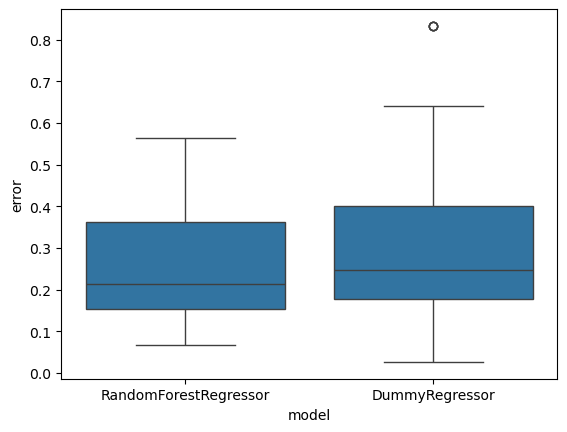

In [15]:
sns.boxplot(data=df.to_pandas(), x="model", y="error")

In [16]:
v1 = df.filter(pl.col('model')=='RandomForestRegressor').group_by('out').mean().sort('out')['error'].to_numpy()

In [17]:
v2 = df.filter(pl.col('model')=='DummyRegressor').group_by('out').mean().sort('out')['error'].to_numpy()

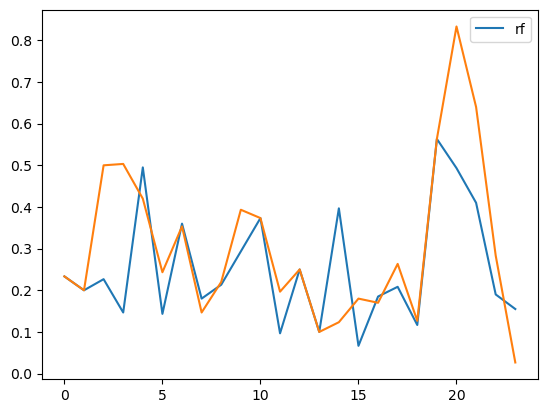

In [20]:
plt.plot(v1, label='rf')
plt.plot(v2)
plt.legend()
plt.show()

In [19]:
v1

array([0.23333333, 0.2       , 0.22666667, 0.14666667, 0.495     ,
       0.14333333, 0.36      , 0.18      , 0.21333333, 0.29333333,
       0.37333333, 0.09666667, 0.25      , 0.1       , 0.39666667,
       0.06666667, 0.185     , 0.20833333, 0.11666667, 0.56333333,
       0.49333333, 0.41      , 0.19      , 0.155     ])